<a href="https://colab.research.google.com/github/oxayavongsa/aai-590-capstone-mental-health/blob/main/soft_voting_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Soft Voting Ensemble Model

In [66]:
# Install Libraries
!pip install tensorflow --quiet
!pip install joblib --quiet

In [65]:
# Import Libraries
import joblib
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, BatchNormalization, ReLU, Add, Multiply, Lambda
from keras import layers, models, regularizers
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='keras')

In [63]:
# Load Files
# Encoded & Scaled Test Features (x_test)
X_test = joblib.load('aai-590-capstone-mental-health/data-assets/X_test_encoded_scaled.pkl')
print("Loaded: X_test_encoded_scaled.pkl")

# True Labels (y-test)
y_test = pd.read_csv('aai-590-capstone-mental-health/data-assets/y_test.csv').squeeze()
print("Loaded: y_test.csv")

Loaded: X_test_encoded_scaled.pkl
Loaded: y_test.csv


In [64]:
# Load the logistic model
logistic_model_path = 'aai-590-capstone-mental-health/notebook-pipeline/models/logistic_pipeline_model.pkl'
logistic_model = joblib.load(logistic_model_path)

logistic_model

Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(class_weight='balanced', l1_ratio=0.5,
                                    max_iter=1000, penalty='elasticnet',
                                    solver='saga'))])

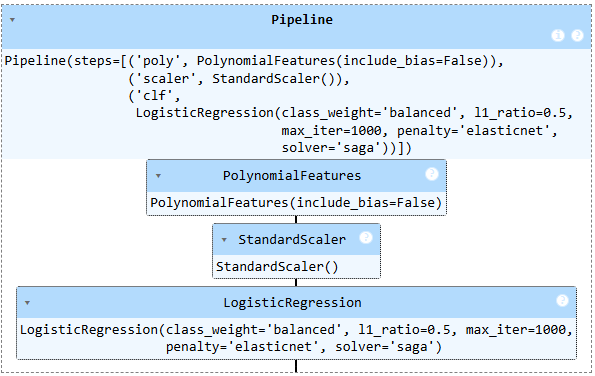

In [22]:
#Define necessary building blocks (GLU, Feature Transformer, Attentive Transformer)
def glu(x, units):
    linear = layers.Dense(units)(x)
    gate = layers.Dense(units, activation='sigmoid')(x)
    return layers.Multiply()([linear, gate])

def feature_transformer(x, units):
    x = layers.Dense(units)(x)
    x = layers.BatchNormalization()(x)
    x = glu(x, units)
    return x

def attentive_transformer(x, prior_scales, units):
    mask_logits = layers.Dense(units)(x)
    mask = layers.Activation('softmax')(mask_logits)
    mask = layers.Multiply()([mask, prior_scales])
    return mask

def tabnet_block(inputs, num_steps=3, feature_dim=64, output_dim=3):
    # Explicitly define output_shape for Lambda
    prior = layers.Lambda(lambda x: K.ones_like(x), output_shape=lambda input_shape: input_shape)(inputs)
    masked_features = inputs
    step_outputs = []

    for step in range(num_steps):
        x = feature_transformer(masked_features, feature_dim)
        mask = attentive_transformer(x, prior, inputs.shape[-1])
        masked_features = layers.Multiply()([inputs, mask])
        out = layers.Dense(feature_dim, activation='relu')(masked_features)
        step_outputs.append(out)
        prior = layers.Multiply()([prior, layers.Lambda(lambda x: 1. - x, output_shape=lambda input_shape: input_shape)(mask)])

    final_out = layers.Add()(step_outputs)
    final_out = layers.Dense(output_dim, activation='softmax')(final_out)
    return final_out

# Rebuild the model
num_features = X_test.shape[1]
num_classes = len(y_test.unique())

input_layer = Input(shape=(X_test.shape[1],))
output_layer = tabnet_block(input_layer, num_steps=3, feature_dim=64, output_dim=3)

tabnet_model = Model(inputs=input_layer, outputs=output_layer)
tabnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Suppress warning about optimizer mismatch
status = tabnet_model.load_weights('aai-590-capstone-mental-health/notebook-pipeline/models/tabnet_model.weights.h5')
if status is not None:
    status.expect_partial()

print("TabNet-inspired model weights loaded successfully.")

TabNet-inspired model weights loaded successfully.


### Predict Probabilities

In [28]:
# Logistic Regression model: Predict probabilities
lr_probs = logistic_model.predict_proba(X_test)

# TabNet Model: Predict probabilities
tabnet_probs = tabnet_model.predict(X_test)

2447/2447 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


### Average Probabilities

In [29]:
# Average the probabilities for soft voting
avg_probs = (lr_probs + tabnet_probs) / 2

### Final Ensemble Predictions

In [30]:
# Take the class with the highest averaged probability
ensemble_preds = np.argmax(avg_probs, axis=1)

### Evaluate the ensemble Model

In [31]:
print("Soft Voting Ensemble Model Evaluation:\n")
print(classification_report(y_test, ensemble_preds))

Soft Voting Ensemble Model Evaluation:

              precision    recall  f1-score   support

           0       0.80      0.82      0.81     31061
           1       0.77      0.76      0.77     26318
           2       0.76      0.76      0.76     20917

    accuracy                           0.78     78296
   macro avg       0.78      0.78      0.78     78296
weighted avg       0.78      0.78      0.78     78296



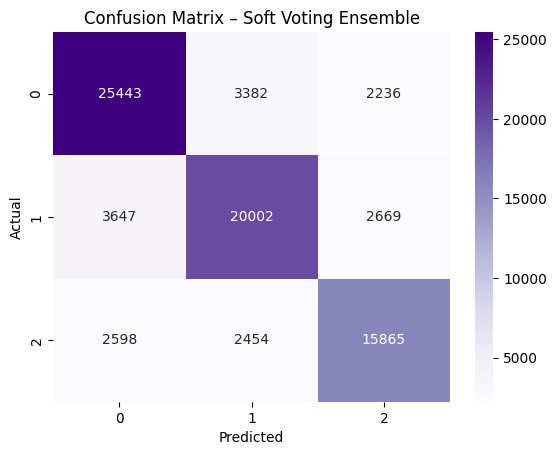

In [33]:
# Confusion matrix visualization
cm = confusion_matrix(y_test, ensemble_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Soft Voting Ensemble")
plt.show()

### ROC Curve & AUC Scores

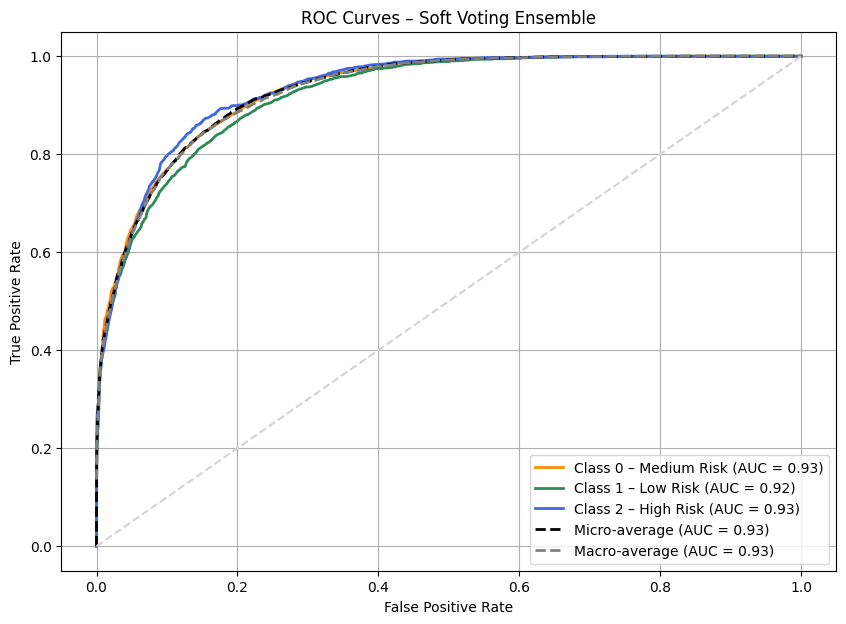

In [37]:
# One-hot encode the target labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Use averaged probabilities from ensemble
# `avg_probs` is already computed from soft voting
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute per-class ROC and AUC
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], avg_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), avg_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves
plt.figure(figsize=(10, 7))

colors = ['darkorange', 'seagreen', 'royalblue']
class_labels = ['Class 0 – Medium Risk', 'Class 1 – Low Risk', 'Class 2 – High Risk']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})',
         linestyle='--', color='black', lw=2)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average (AUC = {roc_auc["macro"]:.2f})',
         linestyle='--', color='gray', lw=2)

plt.plot([0, 1], [0, 1], linestyle='--', color='lightgray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves – Soft Voting Ensemble')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Mental Health Risk Prediction – Model Comparison Table

| **Metric**                  | **Logistic Regression**     | **TabNet-Inspired Model**    | **Soft Voting Ensemble**       |
|----------------------------|-----------------------------|------------------------------|--------------------------------|
| **Accuracy**               | 0.73                        | **0.79**                     | 0.78                           |
| **Macro F1-Score**         | 0.73                        | **0.78**                     | **0.78**                       |
| **Weighted F1-Score**      | 0.73                        | **0.79**                     | 0.78                           |
| **ROC AUC (Micro)**        | 0.84                        | **0.94**                     | 0.93                           |
| **ROC AUC (Macro)**        | 0.84                        | **0.94**                     | 0.93                           |
| **Class 0 AUC (Medium)**   | 0.83                        | **0.94**                     | 0.93                           |
| **Class 1 AUC (Low)**      | 0.83                        | **0.93**                     | 0.92                           |
| **Class 2 AUC (High)**     | 0.85                        | **0.95**                     | 0.93                           |
| **Confusion Matrix**       | Moderate misclassification  | Minor off-diagonal confusion | **Best balance across classes**|
| **Interpretability**       | **High**                    | Moderate                     | Moderate                       |
| **Generalization**         | Good                        | **Very Good**                | **Excellent**                  |

### Model Comparison Visual

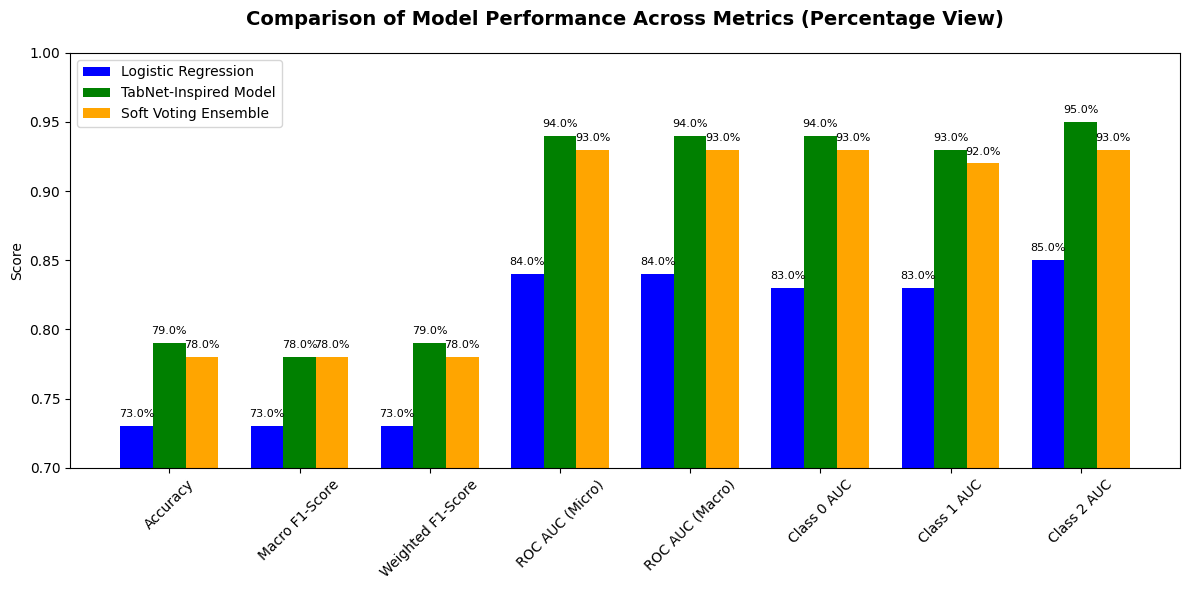

In [61]:
# Metric categories
metrics = [
    "Accuracy", "Macro F1-Score", "Weighted F1-Score",
    "ROC AUC (Micro)", "ROC AUC (Macro)",
    "Class 0 AUC", "Class 1 AUC", "Class 2 AUC"
]

# Scores for each model
logistic = [0.73, 0.73, 0.73, 0.84, 0.84, 0.83, 0.83, 0.85]
tabnet = [0.79, 0.78, 0.79, 0.94, 0.94, 0.94, 0.93, 0.95]
softvote = [0.78, 0.78, 0.78, 0.93, 0.93, 0.93, 0.92, 0.93]

# Convert to percentage
logistic_pct = [round(score * 100, 1) for score in logistic]
tabnet_pct = [round(score * 100, 1) for score in tabnet]
softvote_pct = [round(score * 100, 1) for score in softvote]

x = np.arange(len(metrics))
width = 0.25

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width, logistic, width, label='Logistic Regression', color='blue')
bars2 = ax.bar(x, tabnet, width, label='TabNet-Inspired Model', color='green')
bars3 = ax.bar(x + width, softvote, width, label='Soft Voting Ensemble', color='orange')

# Percentage labels
for bars, scores in zip([bars1, bars2, bars3], [logistic_pct, tabnet_pct, softvote_pct]):
    for bar, score in zip(bars, scores):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, f'{score}%', ha='center', va='bottom', fontsize=8)

# Formatting
ax.set_title("Comparison of Model Performance Across Metrics (Percentage View)", fontsize=14, fontweight='bold', pad=20)
ax.set_ylabel("Score")
ax.set_ylim(0.7, 1.0)
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

### Summary
This bar chart provides a side-by-side comparison of three models, Logistic Regression, TabNet-Inspired Neural Network, and a Soft Voting Ensemble, across multiple evaluation metrics, with a specific emphasis on ROC AUC performance.

* The TabNet-Inspired model consistently outperforms the others, achieving the highest ROC AUC scores across all classes (94–95%), indicating exceptional ability to separate mental health risk levels.

* The Soft Voting Ensemble follows closely behind, maintaining strong and consistent AUC scores around 93%.

* Logistic Regression, while interpretable and reliable, trails with lower AUCs (83–85%), especially in Class 0 and Class 1.

The alignment of macro and micro AUCs in all models suggests consistent class-level discrimination and a balanced dataset. Overall, this visual confirms that TabNet offers the best class separability, especially in high-risk detection, making it the strongest standalone model, while the ensemble adds robustness and balance.